In [4]:
import sys
sys.path.append('../src')

import model.solar_radiation.solar_radiation_calculator as calc
from model.solar_radiation.solar_radiation_calculator import Location
import util.time_util as time_util

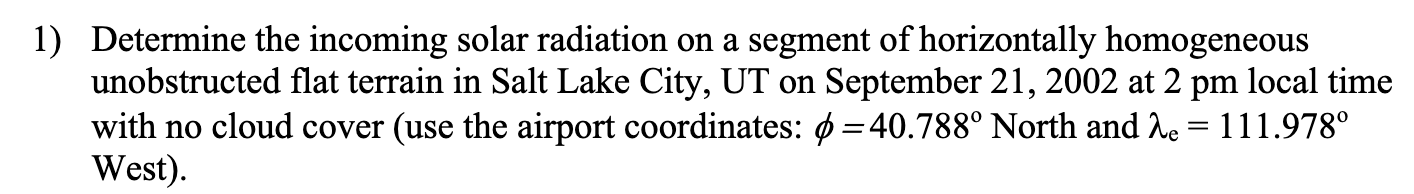

In [6]:
salt_lake_airport = Location(40.788, 111.978, "US/Mountain")
date_time = time_util.make_date_time(month=9, day=21, hour=14, timezone=salt_lake_airport.timezone)

incoming_shortwave = calc.calc_radiation_flux(date_time, salt_lake_airport)
print("Incoming solar radiation: {:.2f} W/m^2".format(incoming_shortwave))

Incoming solar radiation: 769.45 W/m^2
